##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generating Scientific Figure Captions with Fine-Tuned PaliGemma

This notebook explores the use of fine-tuned [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) models for generating captions for scientific figures. [PaliGemma-FT](https://www.kaggle.com/models/google/paligemma-ft) is research-oriented models that are fine-tuned on specific research datasets. We'll focus on the [PaliGemma-3b-ft-scicap-448](https://www.kaggle.com/models/google/paligemma-ft/jax/paligemma-3b-ft-scicap-448) model, specifically trained on the [SciCap](https://arxiv.org/abs/2110.11624) dataset for this task.

The notebook will demonstrate how to utilize this pre-trained model for caption generation, highlighting its potential advantages due to:

* Higher resolution input (448x448): Capturing finer details in scientific figures.
* [SciCap](https://arxiv.org/abs/2110.11624) dataset fine-tuning: Focused training on scientific figure captions.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/PaliGemma/Image_captioning_using_finetuned_PaliGemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model. In this case, you should use a L4 GPU or an A100 GPU, as a T4 will be insufficient:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


## Install Accelerate and restart kernel
Before you start, you will need to install the appropriate packages and setup your environment.

In [2]:
! pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

Restart the kernel after installing packages:

In [3]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## **How to Access PaliGemma:**

Before using PaliGemma for the first time, you'll need to request access to the model through [Hugging Face](https://huggingface.co/google/gemma-2b). This ensures you've accepted the model's terms-of-use.

As we'll be downloading the PaliGemma model weights from the Hugging Face Hub, you'll need a Hugging Face token to verify your acceptance.

If you don't already have a Hugging Face account, you can register for one at [Hugging Face](https://huggingface.co/join). Once you have an account, follow these steps:

1. Go to the [Hugging Face Gemma Model Card](https://huggingface.co/google/gemma-2b) (as PaliGemma is a Gemma variant) and select Request Access.
2. Complete the consent form and accept the terms and conditions.
3. Go to [Hugging Face Hub account settings](https://huggingface.co/settings/tokens) and create a new access token.
3. Copy your token.
4. In Colab, select Secrets  (🔑) and add your Hugging Face Access Token. Store your token under desired name 'HF_TOKEN' and your token under the name value.


In [1]:
from google.colab import userdata
import os

try:
    access_token = userdata.get("HF_TOKEN")
except ImportError:
    access_token = os.environ["HF_TOKEN"]

## Import Libraries

In [2]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import requests
import torch
import matplotlib

## Configuration
In your environment set cuda to lower RAM requirements

In [3]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

## Image: Comparison of Common Loss Functions
We will use the figure comparing common loss functions as an example to generate captions for scientific figures of this nature.
Source: [Wikipedia](https://en.wikipedia.org/wiki/Loss_function).

We'll demonstrate how these models perform on the same scientific figure using various prompts:

* caption en: Generate a general caption in English.
* caption in detail: Provide a more detailed description of the figure.
* caption the figure: Create a concise caption summarizing the figure's content.

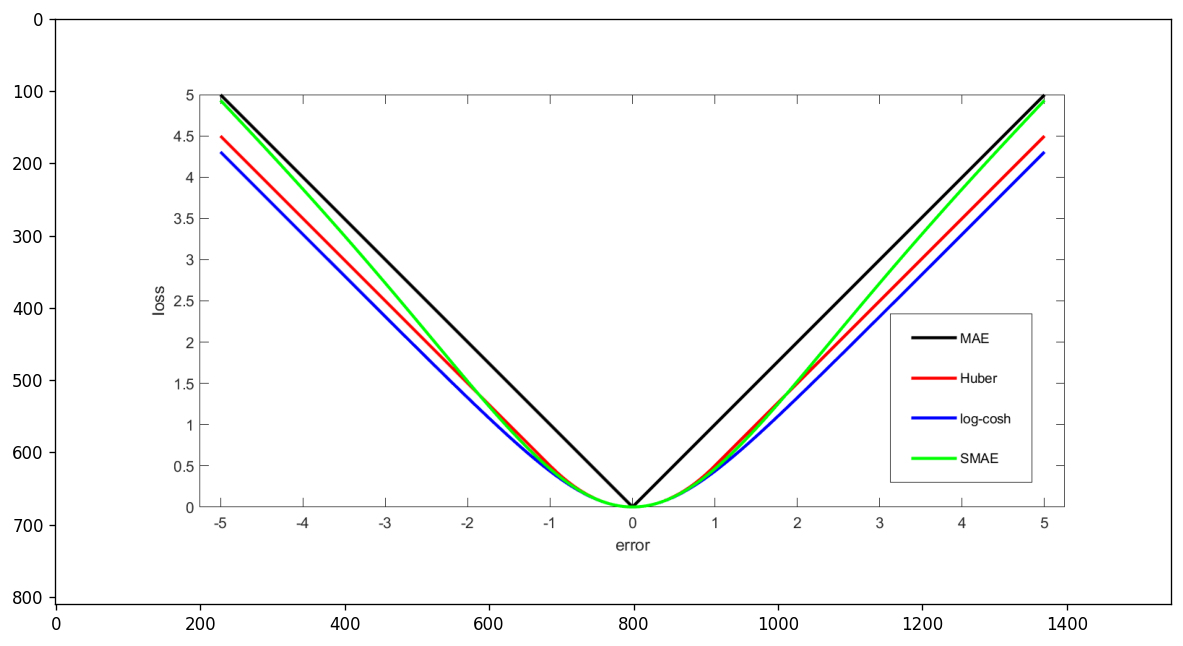

In [10]:
from urllib.request import urlopen

url = "https://upload.wikimedia.org/wikipedia/commons/e/e3/Comparison_of_loss_functions.png?download=true"
image = Image.open(urlopen(url))

matplotlib.pyplot.figure(figsize=(12, 10), dpi=120)
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.show()

## Loads a PaliGemma model and its corresponding tokenizer.

In [11]:
def load_paligemma_model(model_id, access_token):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    dtype = torch.bfloat16

    # Load the model
    model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=dtype,
        device_map=device,
        revision="bfloat16",
        token=access_token,
    ).eval()

    # Load the corresponding tokenizer
    processor = AutoProcessor.from_pretrained(model_id, token=access_token)
    return processor, model

## Generates Captions

In [12]:
def generate_answer(processor, model, image):
    """
    Generates captions for an image using a PaliGemma model with various prompts.

    Args:
      processor (transformers.AutoProcessor): The tokenizer for the PaliGemma model.
      model (transformers.PaliGemmaForConditionalGeneration): The loaded PaliGemma model.
      image: A preprocessed image tensor in the format expected by the model.

    Returns:
      list: A list of generated captions corresponding to the provided prompts.
    """

    prompts = [
        "caption en\n",
        "caption in detail\n",
        "caption the figure\n",
    ]
    images = [image] * len(prompts)

    # Prepare model inputs with padding and truncation
    model_inputs = processor(
        text=prompts, images=images, return_tensors="pt", padding=True
    ).to(model.device)
    input_len = model_inputs["input_ids"].shape[-1]

    # Generate captions with beam search (inference mode)
    with torch.inference_mode():
        generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
        generated_texts = generation[:, input_len:]
        decoded_texts = [
            processor.decode(text, skip_special_tokens=True) for text in generated_texts
        ]

    for i, (prompt, decoded_text) in enumerate(zip(prompts, decoded_texts)):
        print(f"Question: {prompt}")
        print(f"Answer: {decoded_text}\n")

    matplotlib.pyplot.figure(figsize=(12, 10), dpi=120)
    matplotlib.pyplot.imshow(image)
    matplotlib.pyplot.show()

## Inference with the Base Model (PaliGemma-3b-pt-224)
Before we use the fine-tuned models, let's see how the PaliGemma base model responds to the prepared prompts.

Since this model hasn't been fine-tuned specifically for captioning scientific figures, you can expect its responses to be less accurate.

**Here's a quick description of the base model**:

* Transformers PaliGemma 3B weights.
* Pre-trained with 224x224 input images and 128 token input/output text sequences.
* Trained on a mixture of datasets.
* Available in float32, bfloat16, and float16 formats for fine-tuning.

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Question: caption en

Answer: a plot of a comparison of methods .

Question: caption in detail

Answer: graf von figure in the surrounding text

Question: caption the figure

Answer: figure est un diagramme de la figure



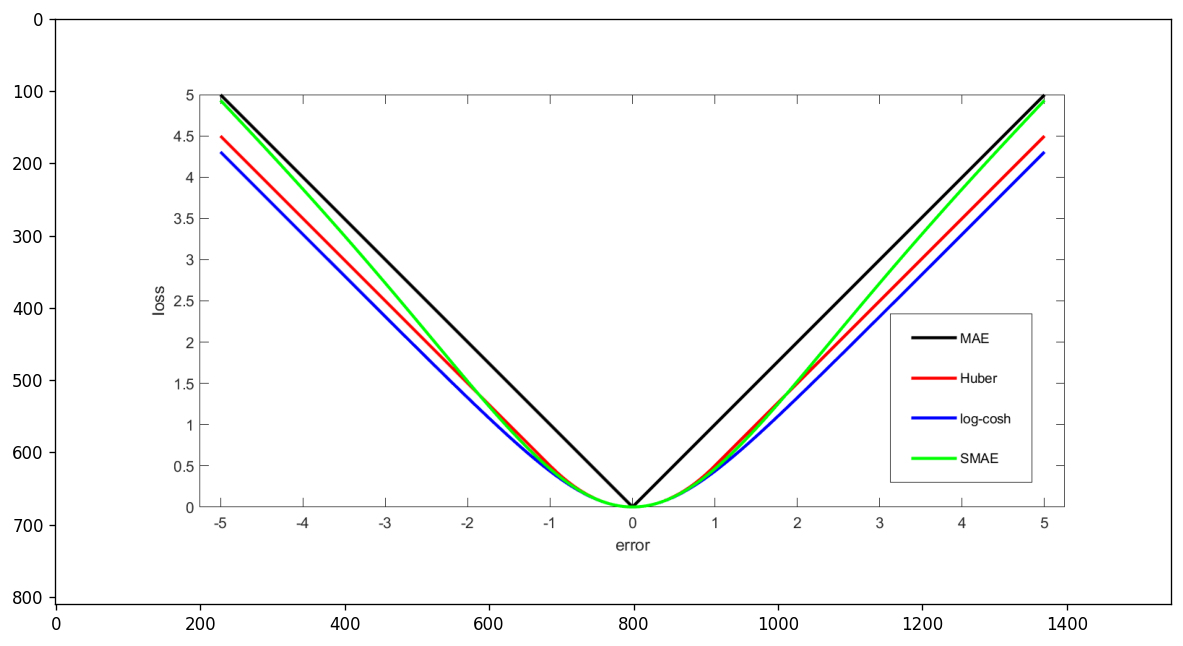

In [13]:
model_id = "google/paligemma-3b-pt-224"
processor, model = load_paligemma_model(model_id, access_token)

generate_answer(processor, model, image)

## Inference with the Fine-Tuned Model (PaliGemma-3b-ft-scicap-224)
We previously explored the base model's performance. Now, let's see how the fine-tuned model responds to the same prompts.

This model (PaliGemma-3b-ft-scicap-224) has been specifically fine-tuned on scientific figures using the SciCap dataset. As a result, you can expect more accurate and relevant captions compared to the base model (PaliGemma-3b-pt-224).

**Here's a quick overview of the fine-tuned model:**
* Transformers PaliGemma 3B weights: This is the starting point for the fine-tuned model.
* Fine-tuned with 224x224 input images: The model is fine-tuned to process images of this size.
* SciCap dataset: This dataset specifically focuses on scientific figures and their captions.

**SciCap: Generating Captions for Scientific Figures**:

You can find more details about the [SciCap dataset](https://arxiv.org/abs/2110.11624) in the following [paper](https://arxiv.org/pdf/2110.11624).

Paper Summary: This paper presents the SciCap dataset, a large collection of scientific figures and their corresponding captions. The authors discuss the challenges of generating captions for scientific figures and the potential benefits of such models.

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Question: caption en

Answer: different values of loss function based on error .

Question: caption in detail

Answer: comparison of four different loss functions with similar nonlinearities , in terms of error .

Question: caption the figure

Answer: shows the comparison of loss functions . the red line shows the relu loss , the black line shows the hinge loss , the blue line shows the quadratic loss and the green line shows the savage loss .



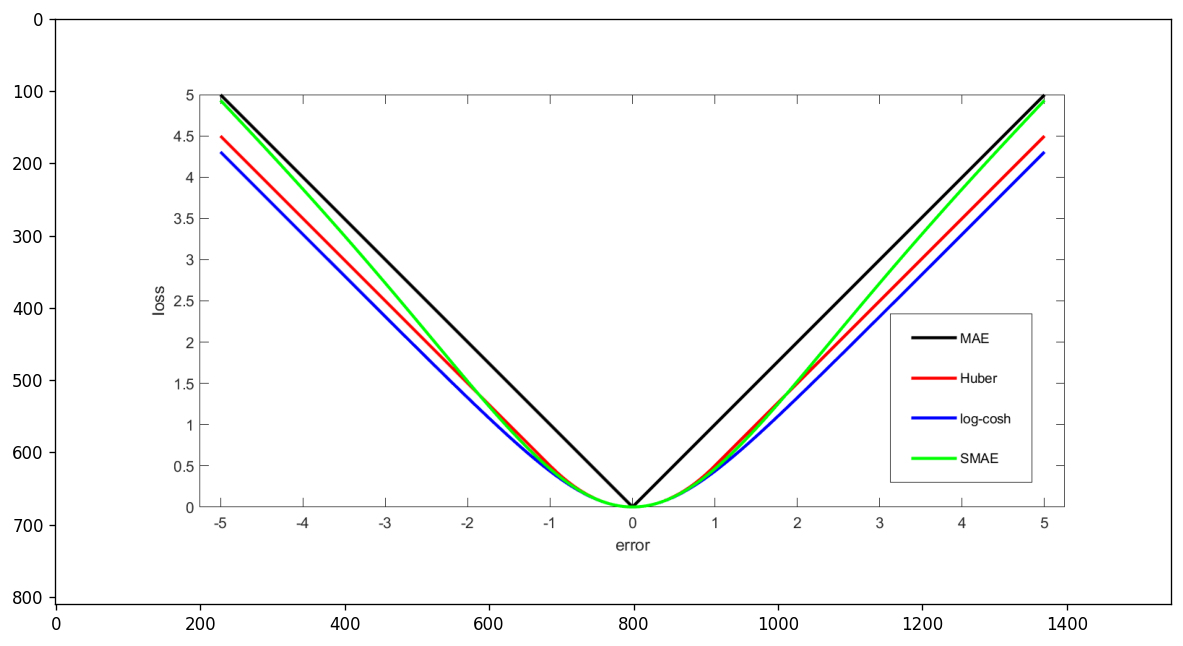

In [14]:
model_id = "google/paligemma-3b-ft-scicap-224"
processor, model = load_paligemma_model(model_id, access_token)

generate_answer(processor, model, image)

## Inference with the Fine-Tuned Model (PaliGemma-3b-ft-scicap-448)

Building on the success of the previous model (PaliGemma-3b-ft-scicap-224), let's explore the capabilities of PaliGemma-3b-ft-scicap-448. This model offers potentially a better captions due to two key improvements:

* Higher Resolution Input (448x448): The model is fine-tuned to process images with a higher resolution, potentially capturing finer details in scientific figures.
* Leveraging SciCap Dataset: Similar to the previous model, it's fine-tuned on the SciCap dataset, specifically designed for scientific figure captioning.

While the model is not fine-tunable, you can still benefit from its pre-trained capabilities for research purposes. The models are available in float32, bfloat16, and float16 formats.

Fine-Tune Configuration:

* For more details on the fine-tuning configuration, you can refer to the [big_vision](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/transfers/scicap.py).

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Question: caption en

Answer: different loss functions . mae , huber , logistic loss , squared error ( sme ) .

Question: caption in detail

Answer: shows the difference between standard mae , huber , logistic loss functions and smae . the horizontal axis shows the error and the vertical shows the difference .

Question: caption the figure

Answer: shows the different loss function . the loss function of mae clearly outperforms the other loss functions .



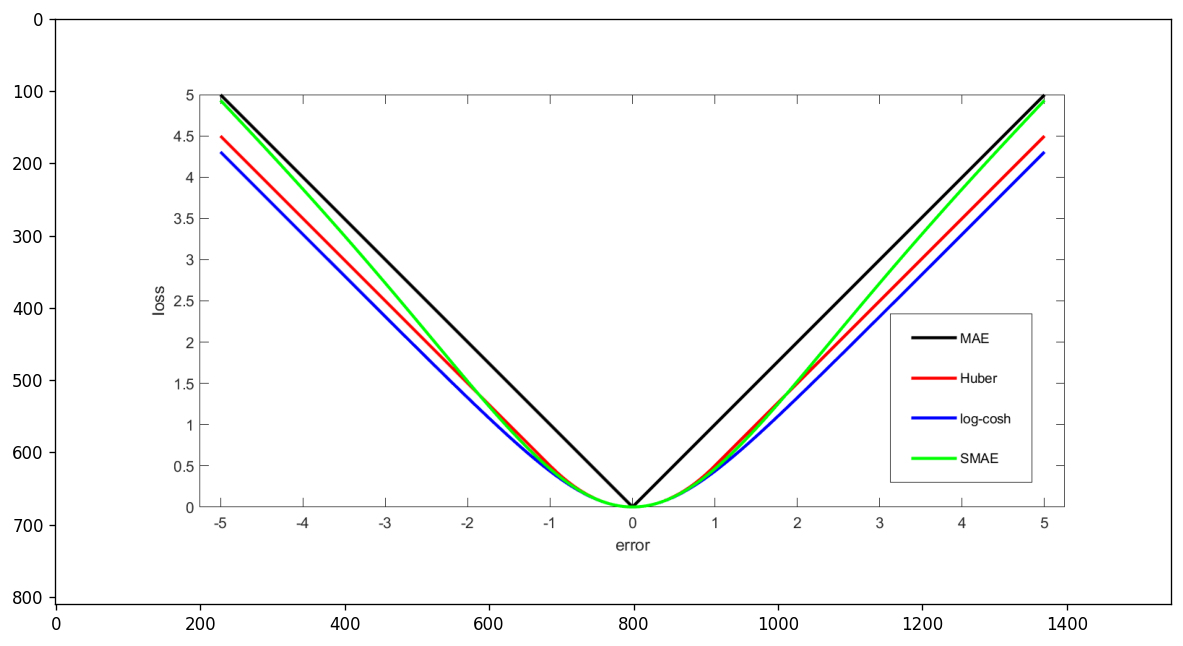

In [15]:
model_id = "google/paligemma-3b-ft-scicap-448"
processor, model = load_paligemma_model(model_id, access_token)

generate_answer(processor, model, image)

# Reference

- [PaliGemma-FT](https://www.kaggle.com/models/google/paligemma-ft): research-oriented models that are fine-tuned on specific research datasets.  
- [SciCap](https://arxiv.org/abs/2110.11624): generating captions for scientific figures.
- [Loss_function](https://en.wikipedia.org/wiki/Loss_function): figure source from Wikipedia.